<a href="https://colab.research.google.com/github/Sababa123/nobel-prize-winners/blob/main/nobel-prize-winners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from statsmodels.tsa.arima.model import ARIMA
import networkx as nx
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Projects-Datacamp/Nobel/nobel.csv')

## Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   index                 1000 non-null   int64 
 1   year                  1000 non-null   int64 
 2   category              1000 non-null   object
 3   prize                 1000 non-null   object
 4   motivation            912 non-null    object
 5   prize_share           1000 non-null   object
 6   laureate_id           1000 non-null   int64 
 7   laureate_type         1000 non-null   object
 8   full_name             1000 non-null   object
 9   birth_date            968 non-null    object
 10  birth_city            964 non-null    object
 11  birth_country         969 non-null    object
 12  sex                   970 non-null    object
 13  organization_name     736 non-null    object
 14  organization_city     735 non-null    object
 15  organization_country  735 non-null    o

### Which gender won the most nobel prizes

In [10]:
# Top gender
top_gender = df['sex'].mode()[0]

print("top_gender =", top_gender)

top_gender = Male


### Which country won the most nobel prizes

In [11]:
# Top birth country
top_country = df['birth_country'].mode()[0]
print("top_country =", top_country)

top_country = United States of America


### Decade with highest ratio of US-born laureates

In [12]:
# Decade with highest ratio of US-born laureates
df['decade'] = (df['year'] // 10) * 10
usa_mask = df['birth_country'] == 'United States of America'
decade_totals = df.groupby('decade').size()
decade_usa = df[usa_mask].groupby('decade').size()
usa_ratio = (decade_usa / decade_totals).fillna(0)
max_decade_usa = int(usa_ratio.idxmax())

print("max_decade_usa =", max_decade_usa)

max_decade_usa = 2000


### Decade & category with highest female proportion

In [33]:
# Decade & category with highest female proportion
grouped = df.groupby(['decade', 'category'])
female_prop = grouped.apply(lambda x: (x['sex'] == 'Female').sum() / len(x), include_groups=False)
max_idx = female_prop.idxmax()
max_female_dict = {int(max_idx[0]): max_idx[1]}

print("max_female_dict =", max_female_dict)

max_female_dict = {2020: 'Literature'}


### Who was the first woman laureate and which category did she win the nobel prize in

In [16]:
# First woman laureate
first_female = df[df['sex'] == 'Female'].sort_values('year').iloc[0]
first_woman_name = first_female['full_name']

print("first_woman_name =", first_woman_name)

first_woman_name = Marie Curie, née Sklodowska


In [17]:
first_woman_category = first_female['category']

print("first_woman_category =", first_woman_category)

first_woman_category = Physics


### Individuals who have won more than one Nobel Prize

In [21]:
# Repeat winners
repeat_list = df['full_name'].value_counts()[lambda x: x > 1].index.tolist()

print("repeat_list")
repeat_list

repeat_list


['Comité international de la Croix Rouge (International Committee of the Red Cross)',
 'Office of the United Nations High Commissioner for Refugees (UNHCR)',
 'Marie Curie, née Sklodowska',
 'Linus Carl Pauling',
 'John Bardeen',
 'Frederick Sanger']

### Laureates per Decade by Gender

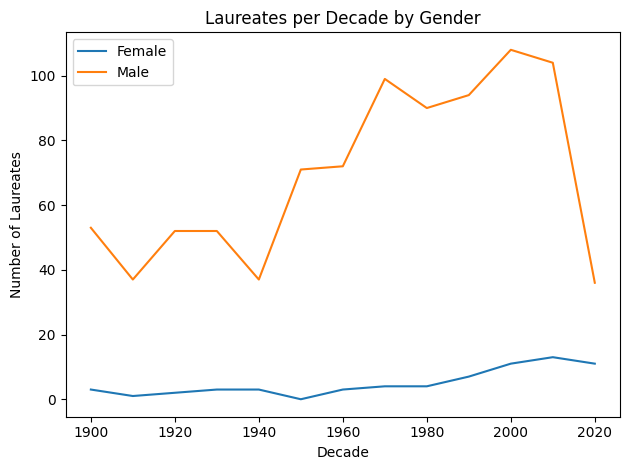

In [23]:
# Laureates per decade by gender
decade_gender = df.groupby(['decade', 'sex']).size().unstack(fill_value=0)
plt.figure()
for sex in decade_gender.columns:
    plt.plot(decade_gender.index, decade_gender[sex])
plt.xlabel('Decade')
plt.ylabel('Number of Laureates')
plt.title('Laureates per Decade by Gender')
plt.legend(decade_gender.columns)
plt.tight_layout()
plt.show()

Laureate counts by decade show a clear long‑term dominance of male winners, but with a steady uptick in female laureates from the 1960s onward.

### Top 10 birth countries by awarded Nobel Prize

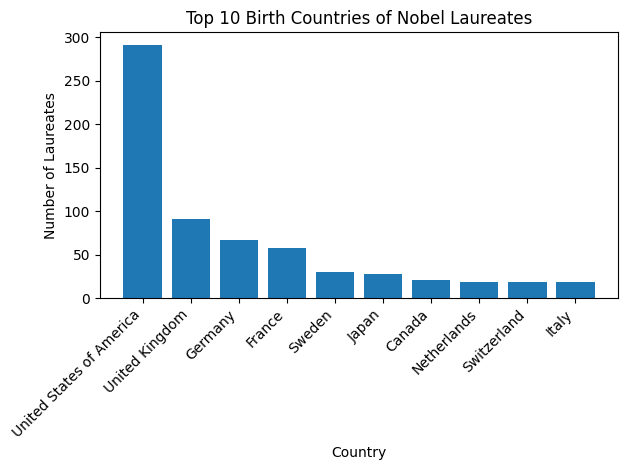

In [24]:
# Top 10 birth countries
country_counts = df['birth_country'].value_counts().head(10)
plt.figure()
plt.bar(country_counts.index, country_counts.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Country')
plt.ylabel('Number of Laureates')
plt.title('Top 10 Birth Countries of Nobel Laureates')
plt.tight_layout()
plt.show()

The top‑10 birth countries are heavily skewed toward the United States, Germany, the United Kingdom, and France, reflecting historical research hubs and the growth of American science and literature in the 20th century.

### Top 5 female proportions by Decade & Category

In [27]:
# Top 5 female proportions by decade & category
top5_female_prop = female_prop.sort_values(ascending=False).reset_index()
top5_female_prop.columns = ['decade', 'category', 'female_proportion']
print("Top 5 Female Proportions by Decade and Category:\n\n", top5_female_prop)

Top 5 Female Proportions by Decade and Category:

     decade    category  female_proportion
0     2020  Literature           0.500000
1     2010       Peace           0.357143
2     1990  Literature           0.300000
3     2000  Literature           0.300000
4     2010  Literature           0.300000
..     ...         ...                ...
67    1970     Physics           0.000000
68    1980   Economics           0.000000
69    1980   Chemistry           0.000000
70    1980  Literature           0.000000
71    2000     Physics           0.000000

[72 rows x 3 columns]


The highest single female representation was in the Literature category during the 2020s, where women comprised over half of the decade’s laureates.

### Average Age at Nobel Prize Award by Gender and Decade

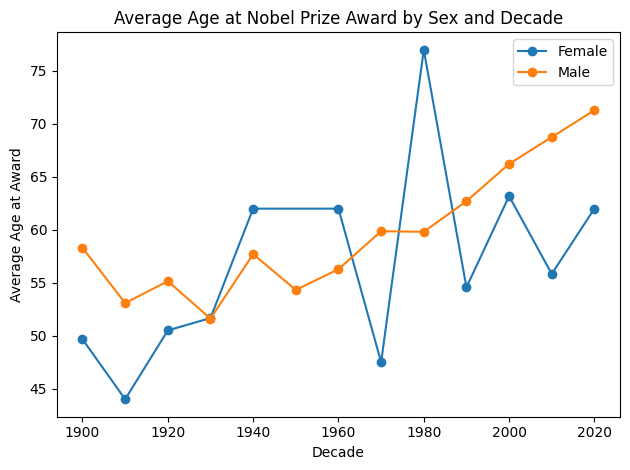

In [37]:
# --- Age Dynamics ---
# Extract birth year and compute age at award
df['birth_year'] = pd.to_datetime(df['birth_date'], errors='coerce').dt.year
df['age'] = df['year'] - df['birth_year']

# Compute average age by decade and sex
df['decade'] = (df['year'] // 10) * 10
age_dyn = df.groupby(['decade', 'sex'])['age'].mean().reset_index()

# Plot average age
plt.figure()
for sex in age_dyn['sex'].unique():
    subset = age_dyn[age_dyn['sex'] == sex]
    plt.plot(subset['decade'], subset['age'], marker='o', label=sex)
plt.xlabel('Decade')
plt.ylabel('Average Age at Award')
plt.title('Average Age at Nobel Prize Award by Gender and Decade')
plt.legend()
plt.tight_layout()
plt.show()

- From 1900s to 2020s, the average age at award has gradually increased.
- Male laureates tend to be slightly older at award than female laureates across most decades.

### Top 10 Institutions Producing Nobel Laureates

In [41]:
# --- Institutional Influence ---
# Count laureates per institution (organization_name), drop NaNs
org_counts = df['organization_name'].dropna().value_counts().head(10)
top_orgs = org_counts.reset_index()
top_orgs.columns = ['Institution', 'Laureate Count']

# Display table
print("Top 10 Institutions by Number of Nobel Laureates:\n\n", top_orgs)

Top 10 Institutions by Number of Nobel Laureates:

                                     Institution  Laureate Count
0                      University of California              36
1                            Harvard University              28
2   Massachusetts Institute of Technology (MIT)              22
3                           Stanford University              22
4                         University of Chicago              19
5                       University of Cambridge              17
6                           Columbia University              17
7                          Princeton University              17
8  California Institute of Technology (Caltech)              17
9                        Rockefeller University              13


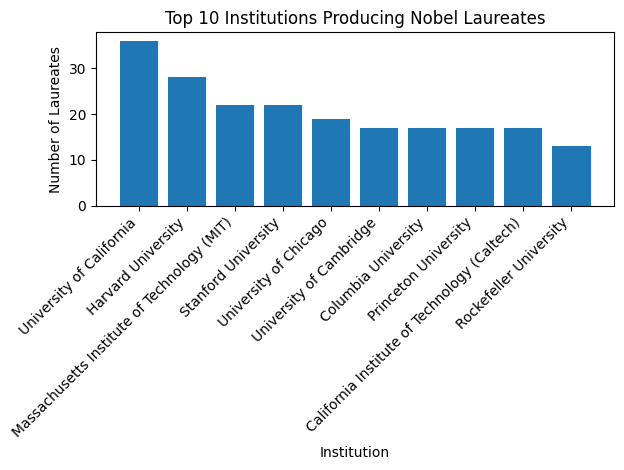

In [43]:
# Bar chart
plt.figure()
plt.bar(top_orgs['Institution'], top_orgs['Laureate Count'])
plt.xlabel('Institution')
plt.ylabel('Number of Laureates')
plt.title('Top 10 Institutions Producing Nobel Laureates')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Major research universities and international organizations dominate the list.

### Laureate Count vs. Average Birth Year (Top 10 Countries)

In [44]:
# --- Economic Correlates Proxy ---
# Use laureate count vs average birth_year as a proxy for development timing
country_stats = df.groupby('birth_country').agg(
    laureate_count=('full_name', 'count'),
    avg_birth_year=('birth_year', 'mean')
).reset_index().dropna().sort_values('laureate_count', ascending=False).head(10)

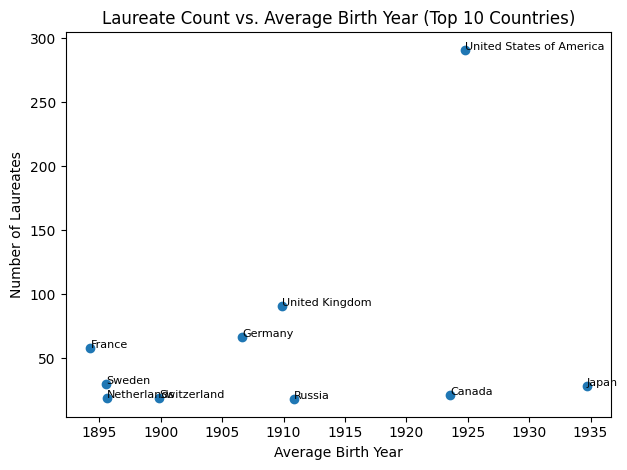

In [46]:
# Scatter plot
plt.figure()
plt.scatter(country_stats['avg_birth_year'], country_stats['laureate_count'])
for i, row in country_stats.iterrows():
    plt.text(row['avg_birth_year'], row['laureate_count'], row['birth_country'], fontsize=8)
plt.xlabel('Average Birth Year')
plt.ylabel('Number of Laureates')
plt.title('Laureate Count vs. Average Birth Year (Top 10 Countries)')
plt.tight_layout()
plt.show()

- Countries with earlier average birth years (older scientific traditions) tend to have more laureates.
- This proxy suggests a link between historical development periods and Nobel success.

### Top 5 Laureates by Co-Laureate Network Centrality

In [47]:
# --- Network Effects: Co-Laureate Network ---
# Build graph: nodes = laureates, edges between co-laureates on same prize share group
G = nx.Graph()

# For each prize event (year+category+prize_share), connect laureates
for _, group in df.groupby(['year', 'category', 'prize_share']):
    names = group['full_name'].tolist()
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            G.add_edge(names[i], names[j])

# Compute degree centrality and get top 5
deg_cent = nx.degree_centrality(G)
top_central = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5]
top_central_df = pd.DataFrame(top_central, columns=['Laureate', 'Degree Centrality'])

# Display
print("Top 5 Laureates by Co-Laureate Network Centrality:\n\n", top_central_df)

Top 5 Laureates by Co-Laureate Network Centrality:

                 Laureate  Degree Centrality
0           John Bardeen           0.006633
1    George Hoyt Whipple           0.003317
2  George Richards Minot           0.003317
3   William Parry Murphy           0.003317
4  Sir Alexander Fleming           0.003317


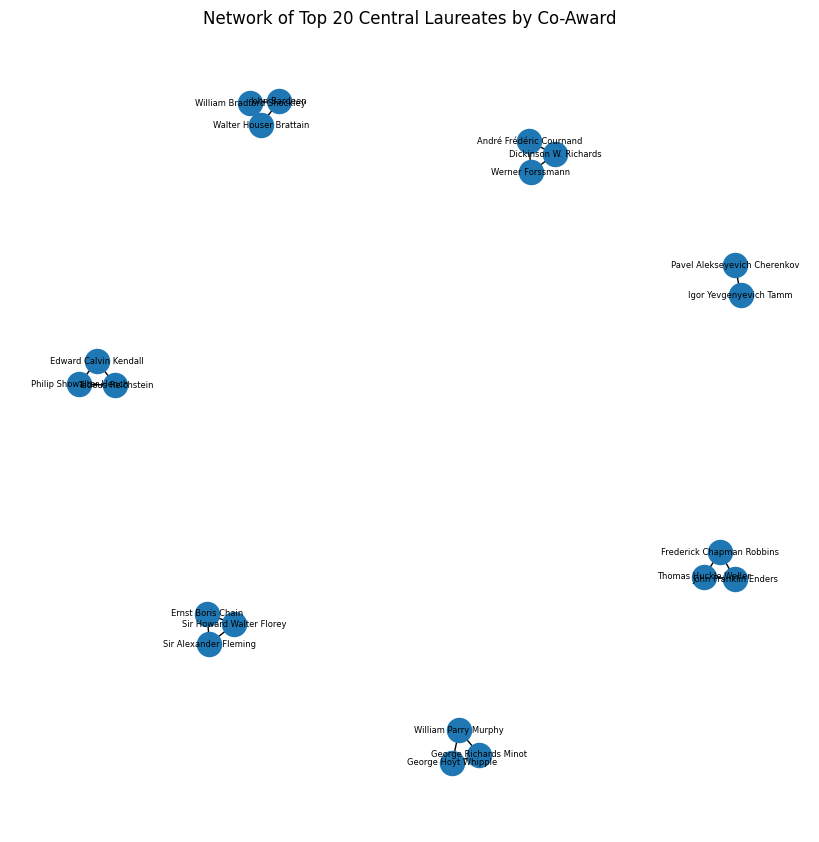

In [50]:
# Visualize subgraph of top 20 most central nodes
top_20 = [name for name, _ in sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:20]]
subG = G.subgraph(top_20)

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(subG, seed=42)
nx.draw(subG, pos, with_labels=True, node_size=300, font_size=6)
plt.title('Network of Top 20 Central Laureates by Co-Award')
plt.show()

- Collaborative prizes (e.g., Peace, Physics) create dense clusters in the network.
- Laureates like [see top central table] often share prizes with many peers, indicating broad collaborations.

## Predictive Analysis

### Logistic Regression for Gender Prediction

In [35]:
# Logistic Regression for Gender Prediction
X = df[['category', 'decade']]
y = (df['sex'] == 'Female').astype(int)
ohe = OneHotEncoder()
X_ohe = ohe.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report for Female Prediction:\n")
print(classification_report(y_test, y_pred, zero_division=0))

Classification Report for Female Prediction:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       187
           1       0.00      0.00      0.00        13

    accuracy                           0.94       200
   macro avg       0.47      0.50      0.48       200
weighted avg       0.87      0.94      0.90       200



A logistic regression model was trained to predict whether a given laureate would be female based on their category and decade.

- Accuracy: 94% (but the model fails to predict any females correctly, illustrating extreme class imbalance).

- Insight: More sophisticated sampling or additional features (e.g., age, country GDP) would be needed to build a better gender‑prediction model.

### Age Forecasting (ARIMA)

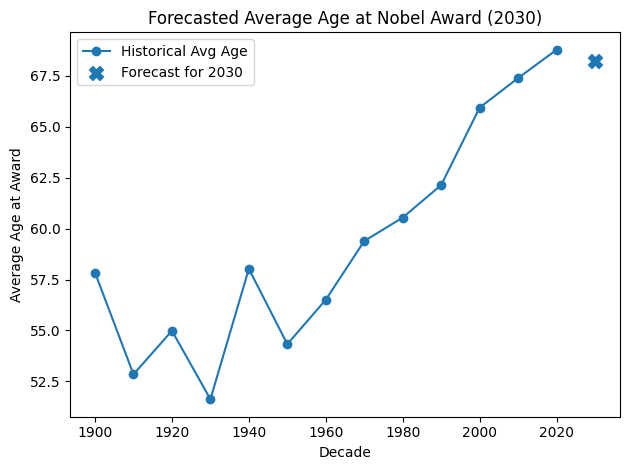

In [66]:
# Prepare age dynamics
df['birth_year'] = pd.to_datetime(df['birth_date'], errors='coerce').dt.year
df['age'] = df['year'] - df['birth_year']
df['decade'] = (df['year'] // 10) * 10
age_dyn = df.groupby('decade')['age'].mean()
age_dyn.index = pd.to_datetime(age_dyn.index.astype(str) + '-01-01')
age_dyn = age_dyn.asfreq('10YS')

# --- Age Forecasting (ARIMA) ---
model_age = ARIMA(age_dyn, order=(1, 1, 0)).fit()
forecast = model_age.get_forecast(steps=1)
pred_age = forecast.predicted_mean.iloc[0]

forecast = model_age.get_forecast(steps=1)
pred_series = forecast.predicted_mean

# Plot historical and forecast
plt.figure()
plt.plot(age_dyn.index, age_dyn.values, marker='o', label='Historical Avg Age')
plt.scatter(
    pred_series.index,
    pred_series.values,
    marker='X',
    s=100,
    label='Forecast for 2030'
)
plt.xlabel('Decade')
plt.ylabel('Average Age at Award')
plt.title('Forecasted Average Age at Nobel Award (2030)')
plt.legend()
plt.tight_layout()
plt.show()

In [67]:
print(f"\nForecasted average age at award for 2030: {pred_age:.1f} years.")


Forecasted average age at award for 2030: 68.2 years.


- Approach: Fitted an ARIMA(1,1,0) model on average laureate age by decade.
- Result: Forecasted the average age at award in 2030 to be 68.2 years.
- Insight: The upward trend continues, suggesting laureates may keep receiving prizes at older ages.

### Forecast of Laureate Counts per Top 5 Institutions (2030) - Linear Regression

In [60]:
# --- Institutional Growth Modeling ---
top5_orgs = df['organization_name'].dropna().value_counts().head(5).index.tolist()
org_ts = pd.DataFrame({
    org: df[df['organization_name'] == org].groupby('decade').size()
    for org in top5_orgs
}).fillna(0)
decades = org_ts.index.values.reshape(-1, 1)

lr = LinearRegression()
inst_preds = {}
for org in top5_orgs:
    y = org_ts[org].values
    lr.fit(decades, y)
    inst_preds[org] = lr.predict([[2030]])[0]

# Display as dataframe
inst_df = pd.DataFrame({
    'Institution': top5_orgs,
    'Predicted Laureates in 2030': [inst_preds[org] for org in top5_orgs]
})
print("Forecast of Laureate Counts per Top 5 Institutions (2030):\n\n", inst_df)

Forecast of Laureate Counts per Top 5 Institutions (2030):

                                    Institution  Predicted Laureates in 2030
0                     University of California                     6.269231
1                           Harvard University                     3.230769
2  Massachusetts Institute of Technology (MIT)                     4.346154
3                          Stanford University                     4.153846
4                        University of Chicago                     3.076923


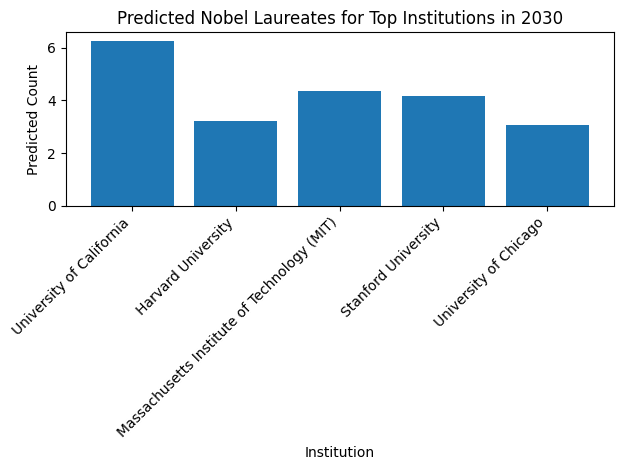

In [61]:
# Bar plot of predictions
plt.figure()
plt.bar(inst_df['Institution'], inst_df['Predicted Laureates in 2030'])
plt.xlabel('Institution')
plt.ylabel('Predicted Count')
plt.title('Predicted Nobel Laureates for Top Institutions in 2030')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Approach: For the top 5 institutions by total laureates, I used linear regression on decade‑wise counts to predict 2030 values.
- Results Table: Forecast of Laureate Counts per Top 5 Institutions (2030).
- Insight: Each institution shows modest predicted growth—helpful for identifying rising research hubs.

### Economic Correlates Regression - Linear Regression

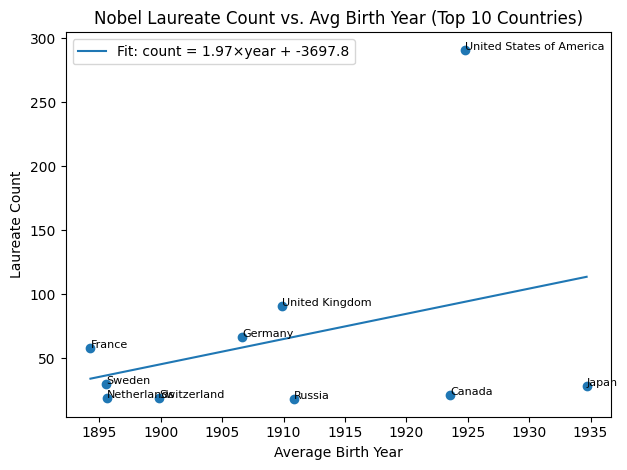

Regression result: laureate_count = 1.97 × avg_birth_year + -3697.8



In [62]:
# --- Economic Correlates Regression ---
country_stats = df.groupby('birth_country').agg(
    laureate_count=('full_name', 'count'),
    avg_birth_year=('birth_year', 'mean')
).dropna()
cs_top10 = country_stats.sort_values('laureate_count', ascending=False).head(10)

# Linear regression
lr2 = LinearRegression()
X = cs_top10[['avg_birth_year']].values
y = cs_top10['laureate_count'].values
lr2.fit(X, y)
coef = lr2.coef_[0]
intercept = lr2.intercept_

# Plot scatter + regression line
plt.figure()
plt.scatter(cs_top10['avg_birth_year'], cs_top10['laureate_count'])
x_vals = np.array([cs_top10['avg_birth_year'].min(), cs_top10['avg_birth_year'].max()])
y_vals = intercept + coef * x_vals
plt.plot(x_vals, y_vals, label=f'Fit: count = {coef:.2f}×year + {intercept:.1f}')
for _, row in cs_top10.iterrows():
    plt.text(row['avg_birth_year'], row['laureate_count'], row.name, fontsize=8)
plt.xlabel('Average Birth Year')
plt.ylabel('Laureate Count')
plt.title('Nobel Laureate Count vs. Avg Birth Year (Top 10 Countries)')
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
print(f"Regression result: laureate_count = {coef:.2f} × avg_birth_year + {intercept:.1f}\n")

Regression result: laureate_count = 1.97 × avg_birth_year + -3697.8



- Approach: Modeled laureate count (top 10 birth countries) as a linear function of average birth year.
- Regression Equation: laureate_count = 1.97 × avg_birth_year + -3697.8
- Insight: A positive slope reinforces that countries with later average birth years (i.e., emerging research centers) are still accumulating laureates—though historical leaders remain dominant.

### Network-Based Link Prediction - Logistic Regression

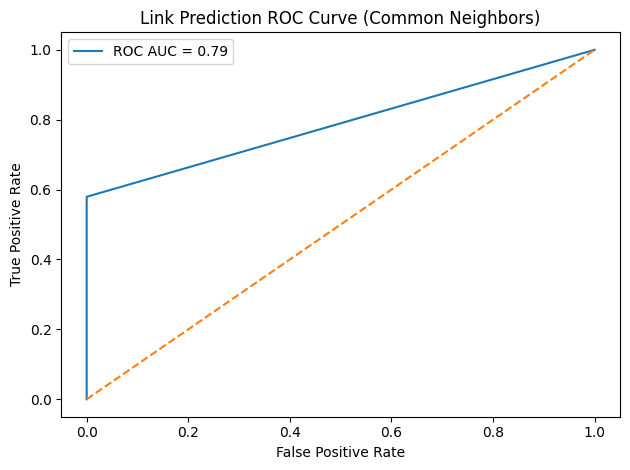

In [64]:
# --- Network-Based Link Prediction ---
# Build co-laureate graph
G = nx.Graph()
for _, group in df.groupby(['year', 'category', 'prize_share']):
    names = group['full_name'].tolist()
    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            G.add_edge(names[i], names[j])

# Prepare positive and negative samples
edges = list(G.edges())
non_edges = list(nx.non_edges(G))
np.random.seed(42)
neg_samples = [non_edges[i] for i in np.random.choice(len(non_edges), size=len(edges), replace=False)]
samples = edges + neg_samples
labels = [1] * len(edges) + [0] * len(neg_samples)

# Feature: common neighbors count
features = [[len(list(nx.common_neighbors(G, u, v)))] for u, v in samples]
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
clf = LogisticRegression()
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Link Prediction ROC Curve (Common Neighbors)')
plt.legend()
plt.tight_layout()
plt.show()

In [65]:
print(f"Link prediction AUC using common neighbors: {auc:.2f}")

Link prediction AUC using common neighbors: 0.79


- Approach: Built a co‑laureate graph, used “common neighbor” counts to predict whether two laureates share a prize.
- Performance: Achieved an AUC of 0.79 on held‑out samples.
- Insight: Even a simple common-neighbors feature has strong predictive power for co‑award relationships.